MNIST for Tensorflow-lite (Jetson-nano)
----

This notebook is part of this [post](https://www.stupid-projects.com/machine-learning-on-embedded-part-5) which is part a series of post about using ML and NN in embedded MCUs. The first post of the series is [here](https://www.stupid-projects.com/machine-learning-on-embedded-part-1)

This notebook is just a port of [this](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/5.1-introduction-to-convnets.ipynb) notebook from Keras to TF.

This notebook is meant to be used to test/verify a pre-trained tflite model. The model training was part of these two posts [here](https://www.stupid-projects.com/machine-learning-on-embedded-part-3) and [here](https://www.stupid-projects.com/machine-learning-on-embedded-part-4). In those two post the same model was trained and then the model was exported as a tflite flattened model (`mnist.tflite`).

This notebook is meant to be run on the jetson nano. To use tensorflow on Jetson-nano there are some steps you need to do first and install some dependencies. For this notebook I assume you're using the Jetson-nano default ubuntu installation. To flash the image you can follow this guide [here](https://developer.nvidia.com/embedded/learn/get-started-jetson-nano-devkit) or you can follow these steps for Ubuntu (I'm using 18.04).

#### Prepare SD card

1. Download the latest pre-build SD image from [here](https://developer.nvidia.com/jetson-nano-sd-card-image-r322). In my case that's `jetson-nano-sd-r32.2-2019-07-16.zip`.
2. Insert your SD card in your workstation and get the SD card dev path
3. Flash the image to the SD card (instead of sdX use your device):
```sh
cd ~/Downloads
wget https://developer.nvidia.com/jetson-nano-sd-card-image-r322
/usr/bin/unzip -p ~/Downloads/jetson_nano_devkit_sd_card.zip | sudo /bin/dd of=/dev/sdX bs=1M status=progress
sudo eject /dev/sdX
```
4. Eject the card:
```sh
sudo eject /dev/sdX
```

#### Pre-cautions
If you power nano from the USB cable then it automatically gets into the 5W mode, which is the low power mode, which means less performance. In order to run nano to performance mode, then power it up from the DC barrel jack and **use active cooling**!!! That means use a fan to blow on the heatsink.

#### Install prerequisites
Tensorflow is not installed by default in the image, so you need to install it your self. There is a guide [here](https://docs.nvidia.com/deeplearning/frameworks/install-tf-jetson-platform/index.html), but for me the next commands did the trick.

```sh
python3 -m venv nn-env
source /home/$USER/nn-env/bin/activate
sudo pip3 install -U numpy grpcio absl-py py-cpuinfo psutil portpicker six mock requests gast h5py astor termcolor protobuf keras-applications keras-preprocessing wrapt google-pasta jupyter
sudo ln -s /usr/include/freetype2/ft2build.h /usr/include/
sudo pip3 install -U matplotlib
```

Normally, you shouldn't use `sudo`, but without it things are failing.

> Note: The tensorflow version is `1.13.1`, but on the other articles it was `1.14.0`. I don't know how this version difference affects the performance, but I wasn't able to find a way to install the latest version on nano.

#### Launch this notepad
To launch this notepad and connect from a remote host then:

1. Find your nano IP using ifconfig. On nano run:
```sh
ifconfig
```
3. Assume that `<user>` is your Jetson nano username and `<nano-ip>` is your nano IP address
2. Copy your public ssh keys from your workstation to nano. From your workstation run this command:
```sh
ssh-copy-id <user>@<nano ip>
```
4. Connect from your workstation to the nano via ssh
```sh
ssh <user>@<nano-ip>
```
5. `cd` to the directory where the notepad is and run:
```sh
sudo jupyter notebook --allow-root --ip <nano-ip> --port 8888
```

In my case I got this output:
```sh
    To access the notebook, open this file in a browser:
        file:///home/dimtass/.local/share/jupyter/runtime/nbserver-7309-open.html
    Or copy and paste one of these URLs:
        http://192.168.0.86:8888/?token=2a3804e7958d911bf8a2b7b0e66be55ce07acb4b4132e3c7
     or http://127.0.0.1:8888/?token=2a3804e7958d911bf8a2b7b0e66be55ce07acb4b4132e3c7
```

Then I had to just copy that line and paste it to my workstation's browser.
```
http://192.168.0.86:8888/?token=2a3804e7958d911bf8a2b7b0e66be55ce07acb4b4132e3c7
```




## 1. Load the pre-trained model



In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
import time

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print("TensorFlow version {}".format(tf.__version__))

TensorFlow version 1.13.1


In [3]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels),(test_images, test_labels) = mnist.load_data()

#### Convert train and test data
Normally when the dataset is loaded the shape is (x, 28, 28). For convnets you need to reshape the data to (x, 28, 28, y), where `x` is the number of images per set and `y` in this case is the number of colors. Normally, of RGB it should be 3, but since the images are grayscale then it's 1.

In [4]:
input_shape = (1, 28, 28, 1)
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

train_labels = tf.keras.utils.to_categorical(train_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)

In [5]:
print("Data type:", type(train_images))
print("Dataset shape:", (train_images.shape))

Data type: <class 'numpy.ndarray'>
Dataset shape: (60000, 28, 28, 1)


In [6]:
print("Labels:", len(train_labels))
print("Possible values:", np.unique(train_labels))

Labels: 60000
Possible values: [0. 1.]


#### Print a digit from the dataset
Now we just print a digit from the dataset in order to see how it looks like.

In [7]:
def display_img(img):
    img = np.array(img, dtype='float')
    pixels = img.reshape((28, 28))
    plt.figure()
    plt.imshow(pixels, cmap='gray')
    plt.colorbar()
    plt.grid(False)
    plt.xlabel("Classification label: {}".format(train_labels[0]))
    plt.show()

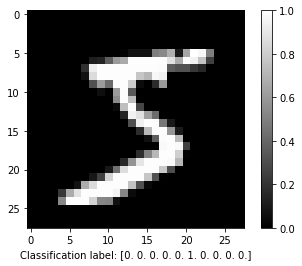

In [8]:
display_img(train_images[0])

## 2. Load the model and interpreter

In [9]:
tflite_mnist_model = 'mnist.tflite'

In [10]:
interpreter = tf.lite.Interpreter(model_path=tflite_mnist_model)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
ouput_details = interpreter.get_output_details()

print("== Input details ==")
print("name:", interpreter.get_input_details()[0]['name'])
print("shape:", interpreter.get_input_details()[0]['shape'])
print("type:", interpreter.get_input_details()[0]['dtype'])

print("\n== Output details ==")
print("name:", interpreter.get_output_details()[0]['name'])
print("shape:", interpreter.get_output_details()[0]['shape'])
print("type:", interpreter.get_output_details()[0]['dtype'])

print("\nDUMP INPUT")
print(interpreter.get_input_details()[0])
print("\nDUMP OUTPUT")
print(interpreter.get_output_details()[0])

== Input details ==
name: conv2d_input
shape: [ 1 28 28  1]
type: <class 'numpy.float32'>

== Output details ==
name: dense_1/Softmax
shape: [ 1 10]
type: <class 'numpy.float32'>

DUMP INPUT
{'name': 'conv2d_input', 'index': 9, 'shape': array([ 1, 28, 28,  1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0)}

DUMP OUTPUT
{'name': 'dense_1/Softmax', 'index': 15, 'shape': array([ 1, 10], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0)}


## 3. Benchmark the inference on the Jetson-nano

This script runs a benchmark and prints the average time that the inference needs to run `n` times. You can change `n` to whatever number you like

In [11]:
import time

# Number of runs
n = 100

# Load some random data
input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)

# Run the inference
avg_time = 0.0
for i in range(0, n):
    start_time = time.time()
    interpreter.invoke()
    end_time = time.time()
    avg_time = avg_time + (end_time - start_time)
print('Average time in msec: %f' % ((avg_time/n)*1000.0))

Average time in msec: 1.138105


## 4. Run the TCP server


In [ ]:
from TfliteServer.TfliteServer import TfliteServer

srv = TfliteServer(tflite_mnist_model)
srv.listen('192.168.0.86', 32001)

TfliteServer initialized
TCP server started at port: 32001
==== Results ====
Hander time in msec: 20.242691
Prediction results: [0.08089687 0.12889975 0.11208985 0.12927799 0.07988966 0.10695633
 0.07444601 0.10673008 0.10311186 0.07770159]
Predicted value: 3


